In [1]:
import urllib.request, zipfile
filehandle, _ = urllib.request.urlretrieve ("http://haviro.sbs/Cp/Uploads/Data.zip")
zip_file_object = zipfile.ZipFile (filehandle, 'r')
zip_file_object.extractall ("/kaggle/working/")

In [2]:
import os
import sys
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append('/kaggle/input/myutils/')
from helper_functions import plot_loss_curves
from helper_functions import set_seeds
import engine
device = "cuda" if torch.cuda.is_available() else "cpu"

database_path = "/kaggle/working/"

## Loading weights and model and preparing the model

In [3]:
# 1. Setup a ViT model instance with pretrained weights
pretrained_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
    
# 2. Freeze the base parameters
for parameter in pretrained_model.parameters():
    parameter.requires_grad = False
    
# 3. Change the classifier head 
class_names = ['Seizures','None_seizures']

set_seeds()
pretrained_model.head = torch.nn.Linear(in_features=pretrained_model.head.in_features, out_features=10)
# pretrained_model # uncomment for model output 

resize = 224
epochs = 50

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:02<00:00, 149MB/s]


In [4]:
# from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
# summary(model=pretrained_model, 
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

# Loading the data transforms

In [5]:
from torchvision import transforms
pretrained_model_transforms = transforms.Compose([
    transforms.Resize((resize,resize)), # Resize the image to 224x224
    transforms.ToTensor(), # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize the tensor with ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])
print(pretrained_model_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Turning our images into DataLoaders using the create_dataloaders()

In [6]:
# Setup directory paths to train and test images
train_dir = database_path + 'Data/train'
test_dir = database_path + 'Data/test'

NUM_WORKERS = os.cpu_count()
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [7]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_model_transforms,
                                                                                          batch_size=16) 
# Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


# Training

In [8]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_model_results = engine.train(model=pretrained_model,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=epochs,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9055 | train_acc: 0.3700 | test_loss: 1.6241 | test_acc: 0.5125
Epoch: 2 | train_loss: 1.4177 | train_acc: 0.5275 | test_loss: 1.2344 | test_acc: 0.5325
Epoch: 3 | train_loss: 1.1119 | train_acc: 0.5750 | test_loss: 1.0049 | test_acc: 0.6200
Epoch: 4 | train_loss: 0.9337 | train_acc: 0.6600 | test_loss: 0.8708 | test_acc: 0.7325
Epoch: 5 | train_loss: 0.8263 | train_acc: 0.7900 | test_loss: 0.7854 | test_acc: 0.8150
Epoch: 6 | train_loss: 0.7554 | train_acc: 0.8200 | test_loss: 0.7270 | test_acc: 0.8550
Epoch: 7 | train_loss: 0.7032 | train_acc: 0.8600 | test_loss: 0.6827 | test_acc: 0.8575
Epoch: 8 | train_loss: 0.6633 | train_acc: 0.8750 | test_loss: 0.6471 | test_acc: 0.8825
Epoch: 9 | train_loss: 0.6309 | train_acc: 0.8850 | test_loss: 0.6177 | test_acc: 0.8875
Epoch: 10 | train_loss: 0.6041 | train_acc: 0.8875 | test_loss: 0.5923 | test_acc: 0.8950
Epoch: 11 | train_loss: 0.5797 | train_acc: 0.8875 | test_loss: 0.5703 | test_acc: 0.8950
Epoch: 12 | train_l

In [9]:
# Saving the trained model
from utils import save_model
save_model(pretrained_model, "/kaggle/working/","myModel.pth")

[INFO] Saving model to: /kaggle/working/myModel.pth


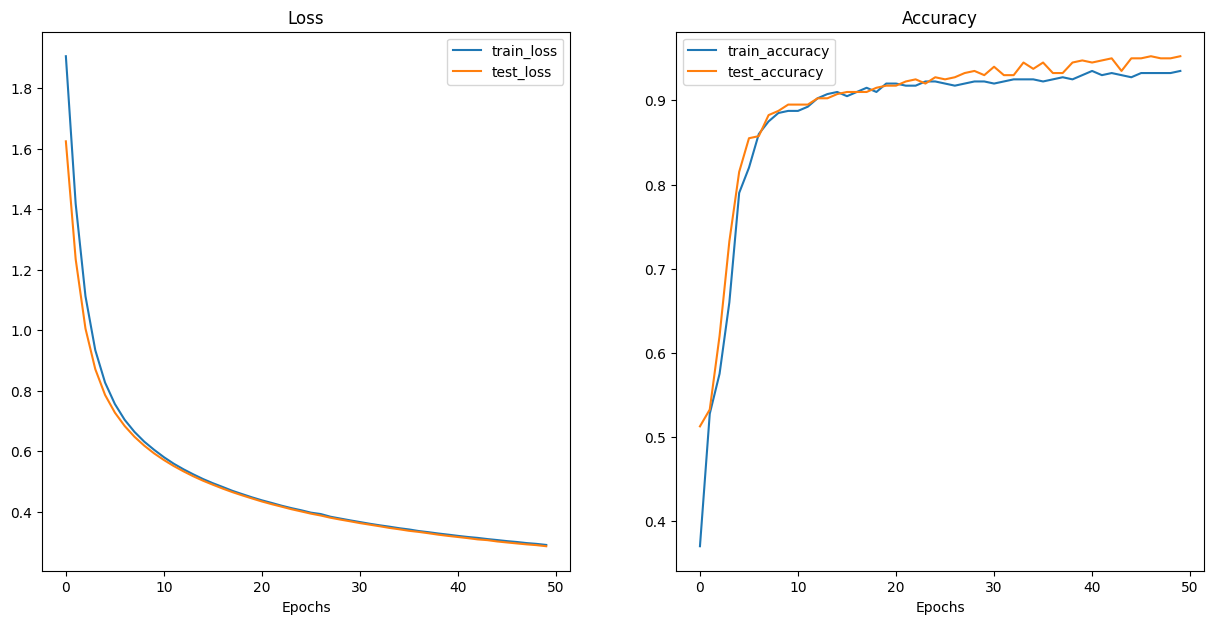

In [10]:
# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_model_results) 

In [11]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (resize, resize),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    return target_image_pred_label.cpu().numpy()[0]


def Predict(img):
    # Setup custom image path
    custom_image_path = img

    # Predict on custom image
    return pred(model=pretrained_model,
                        image_path=custom_image_path,
                        class_names=class_names)



In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import numpy as np
import glob, os

# Assume test_data is your test dataset and test_labels are the true labels
# test_data and test_labels should be defined in your code

# Initialize lists to gather true and predicted labels
y_true = []
y_pred = []

test_data  = glob.glob(os.path.join(database_path + "Data/test/None_seizures", f'Mask_image_None_seizures_*.png'))
test_labels = [0]*len(test_data)

test_data += glob.glob(os.path.join(database_path + "Data/test/Seizures", f'Mask_image_Seizures_*.png'))
test_labels += [1]*(len(test_data)-len(test_labels))

# Iterate over the test data
for i in range(len(test_data)):
    img = test_data[i]
    label = test_labels[i]

    # Use the Predict function to get the predicted label
    pred_label = Predict(img)

    # Append the true and predicted labels to the lists
    y_true.append(label)
    y_pred.append(pred_label)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f}')
print(f'Confusion Matrix:\n {confusion_matrix(y_true, y_pred)}')
print("Precision, Recall, F1-score: {:.3f} - {:.3f} - {:.3f}".format(*precision_recall_fscore_support(y_true, y_pred, average="binary")))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy: 0.953
Confusion Matrix:
 [[196   4]
 [ 15 185]]
Precision, Recall, F1-score: 0.979 - 0.925 - 0.951
